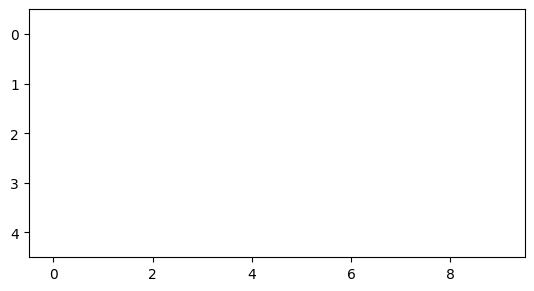

In [4]:
import gym
from gym import spaces
import numpy as np
import pygame

def mult(x,y):
        if(x > y):
            multi = x/y
        else:
            multi = y/x
        return multi
class RectangularEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, width, height, render_mode = None):
        super(RectangularEnv, self).__init__()

        self.width = width
        self.height = height
        self.window_size = 512
        # Define la forma del espacio de observación (en este caso, una imagen binaria)
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, 1, shape=(2,), dtype=int),
            }
        )

        # Define el espacio de acción (puedes personalizar esto según tu entorno)
        self.action_space = spaces.Discrete(4)  # Ejemplo: acciones discretas 0, 1, 2, 3

        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }
        #0 = down, 1 = right, 2= up, 3 = left

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        # Define cualquier otro atributo específico de tu entorno
        self.window = None
        self.clock = None

        # Inicializa el estado inicial de tu entorno
        #self.state = np.zeros((width, height), dtype=np.float32)

    

    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}
    
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        x = self.np_random.randit(0, self.width, dtype=int)
        y = self.np_random.randit(0, self.height, dtype=int)
        self._agent_location = (x,y)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            m = self.np_random.randit(0, self.width, dtype=int)
            n = self.np_random.randit(0, self.height, dtype=int)
            self._target_location = (m,n)

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        x,y = self._agent_location 
        if action == 3:
            if x > 0:  # Verifica si el agente está dentro de los límites
                x -= 1
        elif action == 1:
            if x < self.width - 1:
                x += 1
        elif action == 2:
            if y > 0:
                y -= 1
        elif action == 0:
            if y < self.height - 1:
                y += 1
        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 1 if terminated else 0  # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info


    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            m = mult(self.width, self.height)
            self.window = pygame.display.set_mode((self.window_size, m * self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, m * self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )


# Ejemplo de uso
env = RectangularEnv(width=5, height=10)


